# Linear Systems

Solving linear systems of the form
$$
A \mathbf{x} = \mathbf{b}
$$

where $A$ is symmetric positive definite is arguably one of the most fundamental computations in statistics, machine learning and scientific computation at large. Many problems can be reduced to the solution of one or many (large-scale) linear systems. Some examples include least-squares regression, kernel methods, second-order optimization, quadratic programming, Kalman filtering, linear differential equations and all Gaussian (process) inference. Here, we will solve such a system using a *probabilistic linear solver*.

In [2]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt

plt.style.use("../../probnum.mplstyle")

We begin by creating a random linear system with a symmetric positive definite matrix.

In [3]:
import numpy as np
from scipy.sparse import diags

# Random linear system
np.random.seed(42)
n = 25
k = 10
A = diags(
    np.concatenate([np.arange(1, k + 1), np.arange(k + 1, 0, step=-1)]),
    np.arange(-k, k + 1),
    shape=(n, n),
).toarray()
A += np.random.normal(size=(n, n))
A = 0.5 * (A + A.T) + 10 * np.eye(n)  # Symmetrize and make diagonally dominant
A /= k
b = np.random.normal(size=(n, 1))

print("Matrix condition: {:.2f}".format(np.linalg.cond(A)))
print("Eigenvalues: {}".format(np.linalg.eigvalsh(A)))

Matrix condition: 24.41
Eigenvalues: [ 0.48580904  0.62514308  0.66439741  0.74364588  0.81083848  0.88649772
  0.93374348  0.96332293  1.05955777  1.08313283  1.11218398  1.15148682
  1.23840697  1.29970523  1.34782754  1.3878893   1.41444441  1.44963539
  1.58797406  1.73183581  1.86035582  2.8468586   5.20830562  8.87735305
 11.86101539]


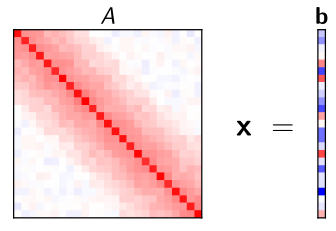

In [4]:
# Plot linear system
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(5, 3.5),
    sharey=True,
    squeeze=False,
    gridspec_kw={"width_ratios": [4, 0.25, 0.25, 0.25]},
)

vmax = np.abs(np.max(np.hstack([A, b])))
vmin = -vmax
axes[0, 0].imshow(A, cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("$A$", fontsize=24)
axes[0, 1].text(0.5, A.shape[0] / 2, "$\\bm{x}$", va="center", ha="center", fontsize=32)
axes[0, 1].axis("off")
axes[0, 2].text(0.5, A.shape[0] / 2, "$=$", va="center", ha="center", fontsize=32)
axes[0, 2].axis("off")
axes[0, 3].imshow(b, cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 3].set_title("$\\bm{b}$", fontsize=24)
for ax in axes[0, :]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Prior Information

We might have access to prior information about the inverse of $A$. Suppose we know something about the eigenvalue structure of $H=A^{-1}$. This is for example the case for Gram matrices generated by a specific kernel. In this case we assume that the average eigenvalue of the inverse is $\bar{\sigma}=\text{avg}(\sigma(H)) \approx 0.6$.

In [5]:
# Average eigenvalue of inverse
print(np.mean(1 / np.linalg.eigvalsh(A)))

0.8613579955299338


Prior information is encoded in random variables modelling $A$ and $H$. Here, we will use our prior information about the spectrum by providing a prior mean for the inverse of the form $H_0 = \operatorname{diag}(\bar{\sigma})$.

In [6]:
from probnum import randvars, linops, linalg

# Prior distribution on A
W0H = linops.Identity(n)
covA = linops.SymmetricKronecker(W0H)
Ainv0 = randvars.Normal(mean=linops.ScalarMult((n, n), scalar=0.6), cov=covA)

## Probabilistic Linear Solvers

We now use a *probabilistic linear solver*, taking into account the prior information we just specified, to solve the linear system. The algorithm iteratively chooses *actions* $\mathbf{s}$ and makes linear *observations* $\mathbf{y}=A \mathbf{s}$ to update its belief over the solution, the matrix and its inverse.

In [7]:
# Probabilistic linear solver
x, Ahat, Ainv, info = linalg.problinsolve(A=A, b=b, Ainv0=Ainv0, maxiter=6)
print(info)
print(Ainv)

{'iter': 6, 'maxiter': 6, 'resid_l2norm': 0.03832436409870799, 'trace_sol_cov': 36.30682422284596, 'conv_crit': 'maxiter', 'rel_cond': None}
<Normal with shape=(25, 25), dtype=float64>


/home/kraemer/Programmes/probnum/probnum/src/probnum/linalg/linearsolvers/matrixbased.py:548: UserWarning: Iteration terminated. Solver reached the maximum number of iterations.
  warnings.warn(


## Numerical Uncertainty

The solver returns random variables $\mathsf{x}$, $\mathsf{A}$ and $\mathsf{H}$, which quantify numerical uncertainty in the solution, the linear operator itself and the estimate of the inverse. For illustration we stopped the solver early after $k=6$ iterations. We plot means and samples from the resulting distributions of $\mathsf{A}$ and $\mathsf{H}$.

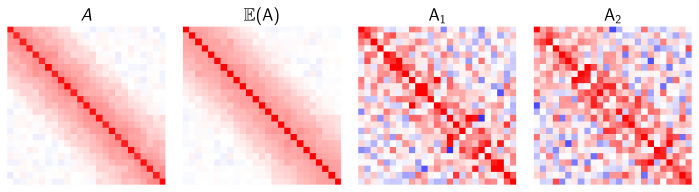

In [8]:
# Draw samples
np.random.seed(42)
Ahat_samples = Ahat.sample(3)
Ainv_samples = Ainv.sample(3)

# Plot
rvdict = {
    "$A$": A,
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathsf{A}_1$": Ahat_samples[0],
    "$\mathsf{A}_2$": Ahat_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

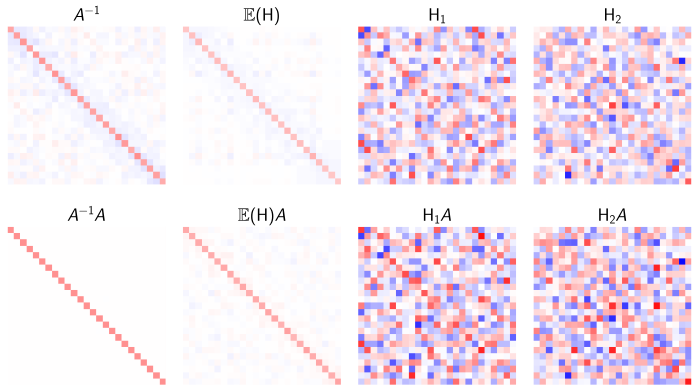

In [9]:
# Plot
rvdict = {
    "$A^{-1}": np.linalg.inv(A),
    "$\mathbb{E}(\mathsf{H})": Ainv.mean.todense(),
    "$\mathsf{H}_1": Ainv_samples[0],
    "$\mathsf{H}_2": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=2, ncols=len(rvdict), figsize=(10, 6), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[0, i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[0, i].set_axis_off()
    axes[0, i].title.set_text(title + "$")

    axes[1, i].imshow(rv @ A, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[1, i].set_axis_off()
    axes[1, i].title.set_text(title + "A$")
plt.tight_layout()

Even though the solver has only explored a subspace of dimension $k \ll n$, the estimates for the matrix and its inverse are already close. This is primarily due to the informative prior that we used. We can see that the uncertainty of the solver about these quantities is still relatively high by looking at the samples from $\mathsf{A}$ and $\mathsf{H}$ .